In [107]:
import os

import numpy as np
import torch

In [108]:
class Net1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = torch.nn.Sequential(
            torch.nn.Conv1d(22, 32, 5, stride=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=3),
        )
        self.c2 = torch.nn.Sequential(
            torch.nn.Conv1d(32, 16, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )

        self.c3 = torch.nn.Sequential(
            torch.nn.Conv1d(16, 16, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=2),
        )

        self.f1 = torch.nn.Linear(16 * 4, 32)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(32, 3)
        #self.softmax = torch.nn.Softmax()

    def forward(self, x: torch.Tensor):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = x.flatten(start_dim=1)
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

In [109]:
from sklearn.model_selection import train_test_split

X, Y = np.load('input.npy'), np.load('label.npy').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4531, 22, 137), (1133, 22, 137), (4531,), (1133,))

In [110]:
y_train

array([1, 2, 0, ..., 1, 1, 1])

In [111]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))  # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # create your dataloader

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))  # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)  # create your dataloader

In [112]:
model = Net1()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [156]:
errs = []
accs = []
softmax = torch.nn.Softmax(dim=1)
correct = 0
for x, y in test_dataloader:
    y_ = model(x)
    y_ = softmax(y_).argmax(dim=1)
    correct += (y_ == y).float().sum()

accuracy = 100 * correct / len(test_dataset)
print("Accuracy = {}".format(accuracy))

for step in range(200):
    tot_err = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        y_ = model(x)
        err: torch.Tensor = loss(y_, y)
        tot_err += err.item()
        err.backward()
        optimizer.step()

    errs.append(tot_err / len(train_dataset))
    print('Error = {}'.format(errs[-1]), end='    ')
    if step % 1 == 0:
        model.eval()
        correct = 0
        for x, y in test_dataloader:
            y_ = model(x)
            y_ = softmax(y_).argmax(dim=1)
            correct += (y_ == y).float().sum()

        accuracy = 100 * correct / len(test_dataset)
        print("Accuracy = {}".format(accuracy))
        accs.append(accuracy.item())
        model.train()

Accuracy = 98.67607879638672
Error = 1.0862531056991956e-08    Accuracy = 98.67607879638672
Error = 9.223129631765644e-09    Accuracy = 98.76434326171875
Error = 7.710342231328874e-09    Accuracy = 98.76434326171875
Error = 6.509975490087358e-09    Accuracy = 98.67607879638672
Error = 6.105469592808497e-09    Accuracy = 98.67607879638672
Error = 4.88536596870154e-09    Accuracy = 98.67607879638672
Error = 4.347117705703272e-09    Accuracy = 98.67607879638672
Error = 3.6340162912028447e-09    Accuracy = 98.76434326171875
Error = 3.015743170525664e-09    Accuracy = 98.58782196044922
Error = 2.6145215808185322e-09    Accuracy = 98.58782196044922
Error = 2.1508149823064234e-09    Accuracy = 98.67607879638672
Error = 1.8975849974941787e-09    Accuracy = 98.67607879638672
Error = 1.5720029716507385e-09    Accuracy = 98.67607879638672
Error = 1.3713920421296436e-09    Accuracy = 98.67607879638672
Error = 1.1691365887133763e-09    Accuracy = 98.67607879638672
Error = 1.0101823331337615e-09    

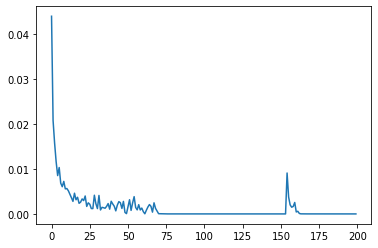

In [120]:
import matplotlib.pyplot as plt

plt.plot(errs)
plt.show()

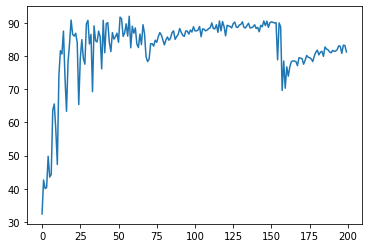

In [121]:
import matplotlib.pyplot as plt

plt.plot(accs)
plt.show()

In [179]:
import librosa
import os
import glob
X__ = []
Y__ = []
test_path = os.path.abspath('audioDB/test')
for file in glob.glob(os.path.join(test_path, '*.wav')):
    source_file = os.path.join(test_path, file)
    y, sr = librosa.load(source_file, sr=16000)
    x1 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    x2 = librosa.feature.spectral_centroid(y=y, sr=sr)
    x3 = librosa.feature.spectral_rolloff(y=y, sr=sr)
    X__.append(np.concatenate([x1, x2, x3]))
    Y__.append((int(file.split('_')[0]), file))

model.eval()
print([x.shape for x in X__])
for x, y in zip(X__, Y__):
    print(y)
    y = y[0]

    if x.shape[1] < 137:
        out = np.zeros((x.shape[0], 137))
        out[:, :x.shape[1]] = x
        x = out

    for s in range(0, len(x[0]) - 136):
        x_ = x[:, s:s + 137]
        x_ = torch.tensor(x_)
        x_.unsqueeze_(0)
        y_ = model(x_)
        y__ = softmax(y_).argmax(dim=1)
        print(' true: ', y, '  model: ', y__.item())

[(22, 145), (22, 52), (22, 175), (22, 164), (22, 105), (22, 202), (22, 164), (22, 147), (22, 155), (22, 172), (22, 252), (22, 112)]
(0, '0_DianaHappy.wav')
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
(0, '0_DianaHappy2.wav')
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  1
(0, '0_DianaHappy3.wav')
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:  0
tensor(0., grad_fn=<SumBackward0>)
 true:  0   model:

In [138]:
Y

array([0, 0, 0, ..., 2, 2, 2])

In [144]:
print(np.unique(Y, return_counts=True),
      np.unique(y_test, return_counts=True),
      np.unique(y_train, return_counts=True), sep='\n')

(array([0, 1, 2]), array([ 778, 4246,  640], dtype=int64))
(array([0, 1, 2]), array([156, 844, 133], dtype=int64))
(array([0, 1, 2]), array([ 622, 3402,  507], dtype=int64))


In [154]:
softmax = torch.nn.Softmax(dim=1)

In [157]:
source_file = os.path.join(test_path, '0_DianaHappy.wav')
y, sr = librosa.load(source_file, sr=16000)

In [160]:
x1 = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
x2 = librosa.feature.spectral_centroid(y=y, sr=sr)
x3 = librosa.feature.spectral_rolloff(y=y, sr=sr)

In [161]:
x1.shape

(20, 145)

In [165]:
y.shape

(74136,)

In [186]:
frames = range(137)
t = librosa.frames_to_time(frames)
t

array([0.        , 0.02321995, 0.04643991, 0.06965986, 0.09287982,
       0.11609977, 0.13931973, 0.16253968, 0.18575964, 0.20897959,
       0.23219955, 0.2554195 , 0.27863946, 0.30185941, 0.32507937,
       0.34829932, 0.37151927, 0.39473923, 0.41795918, 0.44117914,
       0.46439909, 0.48761905, 0.510839  , 0.53405896, 0.55727891,
       0.58049887, 0.60371882, 0.62693878, 0.65015873, 0.67337868,
       0.69659864, 0.71981859, 0.74303855, 0.7662585 , 0.78947846,
       0.81269841, 0.83591837, 0.85913832, 0.88235828, 0.90557823,
       0.92879819, 0.95201814, 0.9752381 , 0.99845805, 1.021678  ,
       1.04489796, 1.06811791, 1.09133787, 1.11455782, 1.13777778,
       1.16099773, 1.18421769, 1.20743764, 1.2306576 , 1.25387755,
       1.27709751, 1.30031746, 1.32353741, 1.34675737, 1.36997732,
       1.39319728, 1.41641723, 1.43963719, 1.46285714, 1.4860771 ,
       1.50929705, 1.53251701, 1.55573696, 1.57895692, 1.60217687,
       1.62539683, 1.64861678, 1.67183673, 1.69505669, 1.71827

In [176]:
torch.save(model, 'models/exp1.model')

In [178]:
modelFFF = torch.load('models/exp1.model')
modelFFF.eval()

Net1(
  (c1): Sequential(
    (0): Conv1d(22, 32, kernel_size=(5,), stride=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c3): Sequential(
    (0): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (f1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (f2): Linear(in_features=32, out_features=3, bias=True)
)